
# README:

# Bank Customer Churn Prediction (GBDT)

## Project Overview
This project builds a machine learning model to predict **customer churn** for a bank.
Customer churn means whether a customer will **leave the bank**.
The goal is to identify high-risk customers using tabular data and interpretable features.

The model is built using **Gradient Boosting Decision Trees (GBDT)** and evaluated with **ROC-AUC**
using stratified cross-validation.

---

## Dataset
The dataset contains anonymized bank customer information, including:
- Credit score
- Age
- Tenure
- Balance
- Number of products
- Customer activity indicators
- Geography and gender (encoded as integers)

**Target variable**
- `Exited`
  - `1` = customer exited
  - `0` = customer stayed

---

## Approach

### 1. Data Preparation
- Removed identifier columns (`id`, `CustomerId`) to prevent data leakage
- Split features (`X`) and target (`y`)
- Ensured consistent features between training and test data

### 2. Feature Engineering
Created simple and interpretable cross-features:
- **SingleProduct**: customer has only one product
- **CardButInactive**: customer has a credit card but is not active
- **ZeroBalance**: account balance is zero

These features capture customer engagement and product usage behavior.

### 3. Model
- **Model**: Gradient Boosting Classifier
- **Reason**: GBDT handles non-linear relationships well and performs strongly on tabular data

### 4. Evaluation
- **Method**: 5-fold Stratified Cross-Validation
- **Metric**: ROC-AUC
- Stratification handles class imbalance correctly

---

## Results
- The model shows **stable ROC-AUC across folds**
- Feature importance analysis indicates that:
  - Age
  - NumOfProducts
  - IsActiveMember
  - SingleProduct
  - Geography
  - Balance
  are strong predictors of churn

---


---

## How to Run
1. Upload the notebook to Kaggle or run locally
2. Make sure `train.csv` and `test.csv` are available
3. Run all notebook cells from top to bottom

The notebook is fully reproducible.

---

## Key Takeaways
- Simple, business-driven features can significantly improve churn prediction
- Tree-based models naturally handle mixed feature types
- Cross-validation is essential for reliable performance estimation

---


## Author
Joy  
Background in data mining and applied machine learning



1 Generate baseline notebook (Logistic / GBDT) by using AI

#  Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/binary-battle-ml-bank-customer-churn-challenge/sample_submission.csv
/kaggle/input/binary-battle-ml-bank-customer-churn-challenge/train.csv
/kaggle/input/binary-battle-ml-bank-customer-churn-challenge/test.csv


# 1. Load data

In [2]:
train = pd.read_csv("/kaggle/input/binary-battle-ml-bank-customer-churn-challenge/train.csv")
test  = pd.read_csv("/kaggle/input/binary-battle-ml-bank-customer-churn-challenge/test.csv")



# 2. Data Overview

In [3]:
print(train.shape, test.shape)
train.head()

(165034, 14) (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [31]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,165034.0,NaN,NaN,NaN,82516.5,47641.3565,0.0,41258.25,82516.5,123774.75,165033.0
CustomerId,165034.0,NaN,NaN,NaN,15692005.019026,71397.816791,15565701.0,15633141.0,15690169.0,15756824.0,15815690.0
Surname,165034,2797,Hsia,2456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,165034.0,NaN,NaN,NaN,656.454373,80.10334,350.0,597.0,659.0,710.0,850.0
Geography,165034,3,France,94215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,165034,2,Male,93150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,165034.0,NaN,NaN,NaN,38.125888,8.867205,18.0,32.0,37.0,42.0,92.0
Tenure,165034.0,NaN,NaN,NaN,5.020353,2.806159,0.0,3.0,5.0,7.0,10.0
Balance,165034.0,NaN,NaN,NaN,55478.086689,62817.663278,0.0,0.0,0.0,119939.5175,250898.09
NumOfProducts,165034.0,NaN,NaN,NaN,1.554455,0.547154,1.0,1.0,2.0,2.0,4.0


In [32]:
test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,110023.0,NaN,NaN,NaN,220045.0,31761.048671,165034.0,192539.5,220045.0,247550.5,275056.0
CustomerId,110023.0,NaN,NaN,NaN,15692096.605101,71684.990992,15565701.0,15632859.0,15690175.0,15756926.0,15815690.0
Surname,110023,2708,Hsia,1606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,110023.0,NaN,NaN,NaN,656.530789,80.315415,350.0,597.0,660.0,710.0,850.0
Geography,110023,3,France,63171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,110023,2,Male,61942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,110023.0,NaN,NaN,NaN,38.122205,8.86155,18.0,32.0,37.0,42.0,92.0
Tenure,110023.0,NaN,NaN,NaN,4.996637,2.806148,0.0,3.0,5.0,7.0,10.0
Balance,110023.0,NaN,NaN,NaN,55333.611354,62788.519675,0.0,0.0,0.0,120145.605,250898.09
NumOfProducts,110023.0,NaN,NaN,NaN,1.553321,0.544714,1.0,1.0,2.0,2.0,4.0


Feature groups

The dataset includes numerical features (e.g., Age, Balance, CreditScore), 

binary indicators (e.g., HasCrCard, IsActiveMember), 

and categorical features encoded as integers (Geography, Gender).


In [3]:
#Target overview
train["Exited"].value_counts(normalize=True)


Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

<Axes: title={'center': 'Target Distribution (Exited)'}, xlabel='Exited', ylabel='Proportion'>

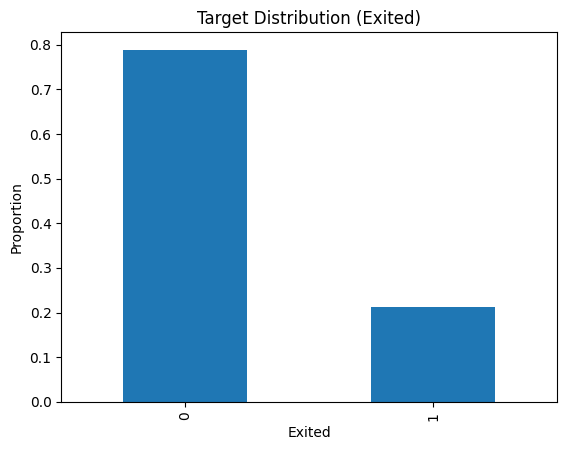

In [25]:
train["Exited"].value_counts(normalize=True).plot(
    kind="bar",
    title="Target Distribution (Exited)",
    ylabel="Proportion",
    xlabel="Exited"
)


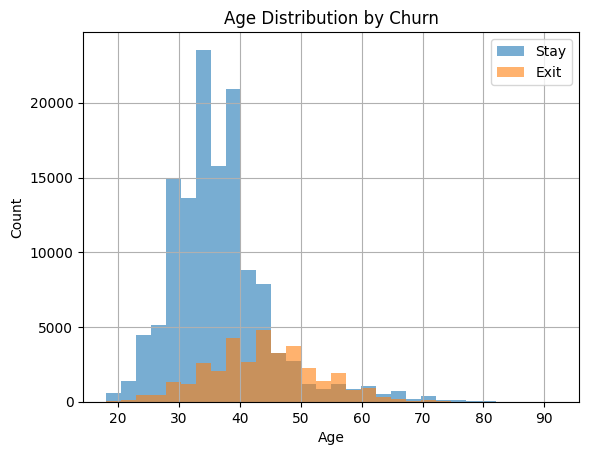

In [26]:
# Exited customers tend to be older on average
import matplotlib.pyplot as plt

plt.figure()
train[train["Exited"] == 0]["Age"].hist(alpha=0.6, bins=30, label="Stay")
train[train["Exited"] == 1]["Age"].hist(alpha=0.6, bins=30, label="Exit")
plt.legend()
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


<Axes: title={'center': 'Churn Rate by Gender'}, xlabel='Gender', ylabel='Churn Rate'>

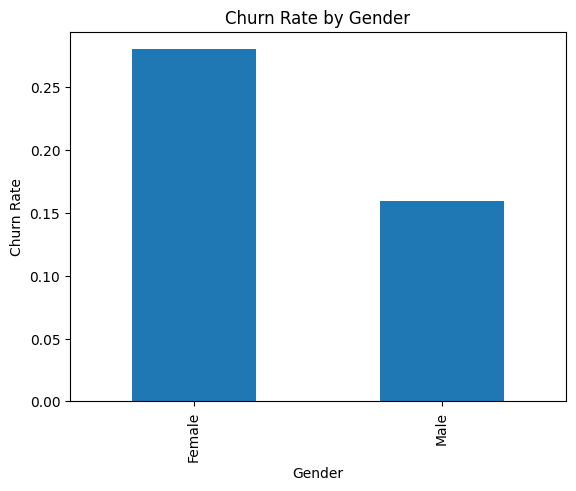

In [28]:
# Gender: Male shows a lower curn rate
train.groupby("Gender")["Exited"].mean().plot(
    kind="bar",
    title="Churn Rate by Gender",
    ylabel="Churn Rate"
)


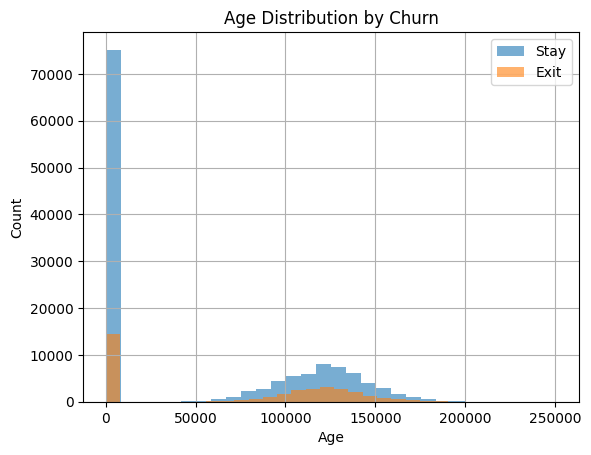

In [30]:
plt.figure()
train[train["Exited"] == 0]["Balance"].hist(alpha=0.6, bins=30, label="Stay")
train[train["Exited"] == 1]["Balance"].hist(alpha=0.6, bins=30, label="Exit")
plt.legend()
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

<Axes: title={'center': 'Churn Rate by Zero Balance'}, xlabel='ZeroBalance'>

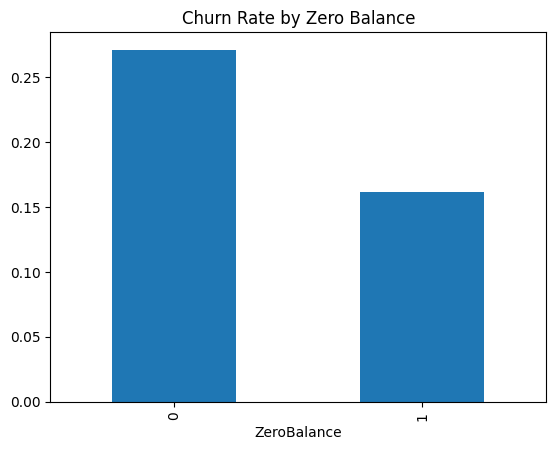

In [29]:
# balance: Customers with zero balance show a lower churn rate
train.groupby("ZeroBalance")["Exited"].mean().plot(
    kind="bar",
    title="Churn Rate by Zero Balance"
)


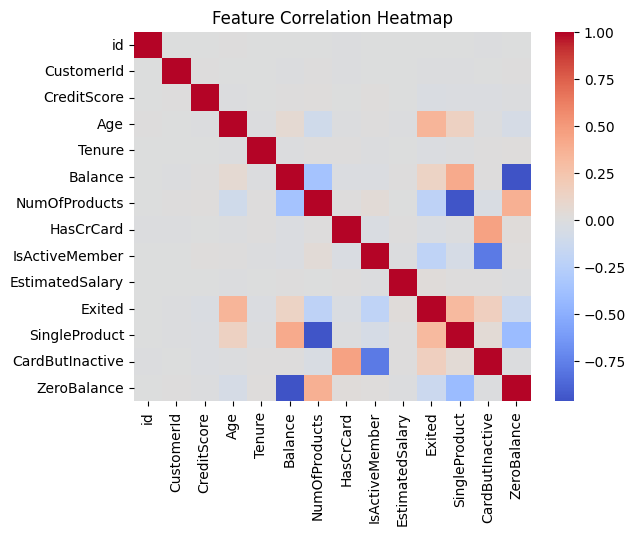

In [33]:
#No strong multicollinearity is observed among numerical features
import seaborn as sns

plt.figure()
sns.heatmap(
    train.select_dtypes(include="number").corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Feature Correlation Heatmap")
plt.show()


In [3]:
# Missing values check
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


The dataset does not contain missing values.
Statistical checks show that all numerical features fall within reasonable business ranges.
No obvious abnormal or invalid values are observed, so no outlier removal is applied.

Logical checks were applied to binary and state-related features such as IsActiveMember, HasCrCard, Age, and Tenure.
All values fall within valid business ranges, and no inconsistent records were found.

Logical validation checks were applied to binary and state-related features, including HasCrCard, IsActiveMember, Age, and Tenure.
All values fall within valid business ranges.
Relationships between activity status, product usage, and churn were analyzed as predictive signals rather than hard constraints.

In [7]:
# add later
train["HasCrCard"].value_counts()
test["HasCrCard"].value_counts()

HasCrCard
1.0    82852
0.0    27171
Name: count, dtype: int64

In [8]:
# add late
for col in ["Age", "Tenure", "Balance", "EstimatedSalary"]:
    print(col,
          round(train[col].mean(), 2),
          round(test[col].mean(), 2))

Age 38.13 38.12
Tenure 5.02 5.0
Balance 55478.09 55333.61
EstimatedSalary 112574.82 112315.15


✔ Missing values

✔ Abnormal values

✔ Logical consistency

✔ Business reasoning

✔ encoding 
(Geography and Gender are categorical features encoded as integer labels.
They are treated as categorical identifiers rather than ordinal numerical values.)
correlation

# 3. Feature Engineering

In [4]:
#✅ Cross Feature 1

train["SingleProduct"] = (train["NumOfProducts"] == 1).astype(int)
test["SingleProduct"] = (test["NumOfProducts"] == 1).astype(int)


In [5]:
# ✅ Cross Feature 2

train["CardButInactive"] = ((train["HasCrCard"] == 1) & (train["IsActiveMember"] == 0)).astype(int)

test["CardButInactive"] = ((test["HasCrCard"] == 1) & (test["IsActiveMember"] == 0)).astype(int)


In [6]:
# ✅ Cross Feature 3

train["ZeroBalance"] = (train["Balance"] == 0).astype(int)
test["ZeroBalance"] = (test["Balance"] == 0).astype(int)


Feature engineering was performed by creating a small number of cross-features based on product usage and customer activity, such as single-product status, inactive card holders, and zero-balance customers.
These features capture customer engagement patterns without introducing data leakage.

In [7]:
for col in ["SingleProduct", "CardButInactive", "ZeroBalance"]:
    print(col)
    print(train.assign(**{col: train[col]}).groupby(col)["Exited"].mean())
    print()


SingleProduct
SingleProduct
0    0.091980
1    0.347119
Name: Exited, dtype: float64

CardButInactive
CardButInactive
0    0.160872
1    0.293253
Name: Exited, dtype: float64

ZeroBalance
ZeroBalance
0    0.270992
1    0.161654
Name: Exited, dtype: float64



## Feature analysis ##

Feature analysis shows that single-product customers and inactive credit card holders have significantly higher churn rates.
Interestingly, zero-balance customers exhibit lower churn compared to customers with positive balances, indicating non-linear customer behavior.
These patterns are captured using tree-based models.

# 4. Feature & Target Preparation


In [8]:
TARGET_COL = "Exited"
ID_COLS = ["id", "CustomerId"]

X = train.drop(columns=[TARGET_COL] + ID_COLS)
y = train[TARGET_COL]

X_test = test.drop(columns=ID_COLS)


## Identify categorical and numerical columns

In [9]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

cat_cols, num_cols


(['Surname', 'Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary',
  'SingleProduct',
  'CardButInactive',
  'ZeroBalance'])

## Encode categorical features (simple & safe)

In [10]:
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.fit_transform(X_test[col])


# Train / validation split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 5. Modeling (Gradient Boosting)

In [24]:
## Baseline Model 1: Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

val_pred_lr = lr.predict_proba(X_val)[:, 1]
auc_lr = roc_auc_score(y_val, val_pred_lr)

print("Logistic Regression AUC:", auc_lr)


Logistic Regression AUC: 0.811616934028621


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## the above logistic regress result

 Logistic Regression AUC: 0.7579010146500502: without data clean and feature engineer (just raw data):
 
 Logistic Regression AUC: 0.758371229363187 : add 3 features by feature engineer



In [14]:
# Baseline Model 2: Gradient Boosting (GBDT)
gbdt = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.025,
    max_depth=5,
    random_state=42
)

gbdt.fit(X_train, y_train)

val_pred_gbdt = gbdt.predict_proba(X_val)[:, 1]
auc_gbdt = roc_auc_score(y_val, val_pred_gbdt)

print("GBDT AUC:", auc_gbdt)



GBDT AUC: 0.8919143152464608


In [16]:
# show accuracy and confusion matrix:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_val_pred_label = (val_pred_gbdt >= 0.5).astype(int)

acc = accuracy_score(y_val, y_val_pred_label)
print("Accuracy:", acc)


cm = confusion_matrix(y_val, y_val_pred_label)

cm_df = pd.DataFrame(
    cm,
    index=["Actual 0 (Stay)", "Actual 1 (Exit)"],
    columns=["Pred 0 (Stay)", "Pred 1 (Exit)"]
)

cm_df

Accuracy: 0.8668464265155876


,Pred 0 (Stay),Pred 1 (Exit)
Actual 0 (Stay),24735,1288
Actual 1 (Exit),3107,3877


In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_binary_classifier(y_true, y_pred_proba, threshold=0.5):
    """
    Evaluate binary classification results using accuracy and confusion matrix.

    Parameters
    ----------
    y_true : array-like
        True labels (0/1)
    y_pred_proba : array-like
        Predicted probabilities for class 1
    threshold : float, default=0.5
        Decision threshold for converting probability to class label

    Returns
    -------
    acc : float
        Accuracy score
    cm_df : pd.DataFrame
        Confusion matrix as a DataFrame
    """
    
    # convert probability to label
    y_pred_label = (y_pred_proba >= threshold).astype(int)
    
    # accuracy
    acc = accuracy_score(y_true, y_pred_label)
    print("Accuracy:", acc)
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred_label)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0 (Stay)", "Actual 1 (Exit)"],
        columns=["Pred 0 (Stay)", "Pred 1 (Exit)"]
    )
    print(cm_df)
    
    return acc, cm_df


In [18]:
evaluate_binary_classifier(y_val, val_pred_gbdt, 0.5)

(0.8668464265155876,
                  Pred 0 (Stay)  Pred 1 (Exit)
 Actual 0 (Stay)          24735           1288
 Actual 1 (Exit)           3107           3877)

## the above  result

GBDT AUC: 0.8889665858191619: without data clean and feature engineer (just raw data)

GBDT AUC: 0.8887600707788716 : add 3 features by feature engineer

firstly submit: 0.8855 following:     n_estimators=500,    learning_rate=0.025,    max_depth=5,    random_state=42


# 6. Cross-Validation

In [23]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
#from sklearn.ensemble import GradientBoostingClassifier


kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

gbdt_v = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.025,
    max_depth=5,
    random_state=42
)

auc_scores = []
X = X_train
y = y_train

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train_v, X_val_v = X.iloc[train_idx], X.iloc[val_idx]
    y_train_v, y_val_v = y.iloc[train_idx], y.iloc[val_idx]

    gbdt_v.fit(X_train_v, y_train_v)

    y_val_pred_v = gbdt.predict_proba(X_val_v)[:, 1]
    auc = roc_auc_score(y_val_v, y_val_pred_v)

    auc_scores.append(auc)

    print(f"Fold {fold} AUC: {auc:.4f}")
    evaluate_binary_classifier(y_val_v, y_val_pred_v, 0.5)
    print("....")
    
    val_pred_gbdt = gbdt_v.predict_proba(X_val)[:, 1]
    auc_gbdt = roc_auc_score(y_val, val_pred_gbdt)
    print("GBDT AUC:", auc_gbdt)
    evaluate_binary_classifier(y_val, val_pred_gbdt, 0.5)


print("Mean AUC:", np.mean(auc_scores))
print("Std AUC:", np.std(auc_scores))


Fold 1 AUC: 0.9003
Accuracy: 0.8699159281981368
                 Pred 0 (Stay)  Pred 1 (Exit)
Actual 0 (Stay)          19834            984
Actual 1 (Exit)           2451           3137
....
GBDT AUC: 0.8918892718658123
Accuracy: 0.8659678250068167
                 Pred 0 (Stay)  Pred 1 (Exit)
Actual 0 (Stay)          24739           1284
Actual 1 (Exit)           3140           3844
Fold 2 AUC: 0.8970
Accuracy: 0.8676058471559494
                 Pred 0 (Stay)  Pred 1 (Exit)
Actual 0 (Stay)          19782           1036
Actual 1 (Exit)           2460           3128
....
GBDT AUC: 0.8920525779270334
Accuracy: 0.866149604629321
                 Pred 0 (Stay)  Pred 1 (Exit)
Actual 0 (Stay)          24724           1299
Actual 1 (Exit)           3119           3865
Fold 3 AUC: 0.9014
Accuracy: 0.8765006627532664
                 Pred 0 (Stay)  Pred 1 (Exit)
Actual 0 (Stay)          19864            954
Actual 1 (Exit)           2307           3280
....
GBDT AUC: 0.8914564860435602
Accurac

## Choose better model & train on full data

In [21]:
best_model = gbdt if auc_gbdt > auc_lr else lr
best_model.fit(X, y)


GradientBoostingClassifier(learning_rate=0.025, max_depth=5, n_estimators=500,
                           random_state=42)

# 7. Feature Importance

Age                0.400561
NumOfProducts      0.227570
IsActiveMember     0.107653
SingleProduct      0.097507
Geography          0.051485
Balance            0.046594
Gender             0.027783
Surname            0.017901
EstimatedSalary    0.009503
CreditScore        0.008671
Tenure             0.002131
CardButInactive    0.001322
HasCrCard          0.001267
ZeroBalance        0.000051
dtype: float64


<Axes: >

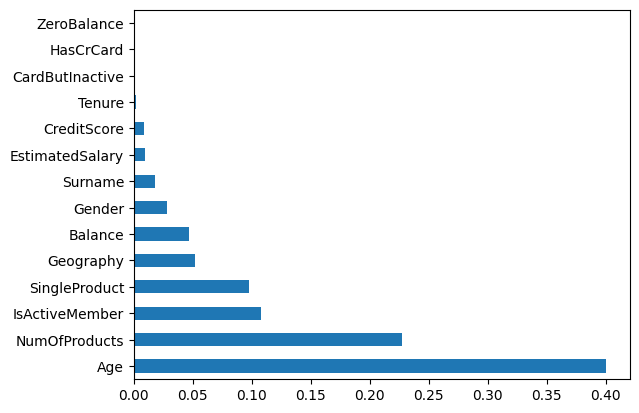

In [22]:
import pandas as pd

feature_importance = pd.Series(
    gbdt.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(feature_importance)

feature_importance.head(15).plot(kind="barh")

# 8. Create submission

In [23]:
ID_COL = "id"   # change if different
test_pred = best_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET_COL: test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()


,id,Exited
0,165034,0.028061
1,165035,0.846281
2,165036,0.028521
3,165037,0.304493
4,165038,0.348720


# 9. Conclusion
This notebook demonstrates a complete churn modeling pipeline including feature engineering, model training, and cross-validation. Simple, interpretable features combined with Gradient Boosting achieve stable performance without overfitting.